In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
redundant_elements = ('headers', 'footers', 'quotes')

newsgroups_train = fetch_20newsgroups(
    subset='train', categories=categories, shuffle=True, random_state=42, remove=redundant_elements)
newsgroups_test = fetch_20newsgroups(
    subset='test', categories=categories, remove=redundant_elements, shuffle=True, random_state=42)

y_train, y_test = newsgroups_train.target, newsgroups_test.target

In [14]:
from keras.backend import clear_session

clear_session()

In [3]:
import re
import pandas as pd
import string


def alphanumeric(x): return re.sub(r"""\w*\d\w*""", ' ', x)
def punc_lower(x): return re.sub(
    '[%s]' % re.escape(string.punctuation), ' ', x.replace("\n", " ").replace("\t", " "))


pd_train = pd.DataFrame({'data': newsgroups_train.data, 'target': newsgroups_train.target})
pd_train['data'] = pd_train.data.map(alphanumeric).map(punc_lower)

pd_test = pd.DataFrame({'data': newsgroups_test.data, 'target': newsgroups_test.target})
pd_test['data'] = pd_test.data.map(alphanumeric).map(punc_lower)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


class LemmaTokenizer:

    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


vectorizer = TfidfVectorizer(
    sublinear_tf=True, lowercase=True, tokenizer=LemmaTokenizer(), max_df=0.5, min_df=0.0005, stop_words="english")

x_train = vectorizer.fit_transform(pd_train.data)
x_test = vectorizer.transform(pd_test.data)
# F-score:
x_train.nnz / float(x_train.shape[0])

c:\Users\io\PycharmProjects\test\.venv\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


59.98360655737705

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential


model = Sequential()

model.add(Dense(1500, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(
    optimizer='adam', loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1500)              16483500  
                                                                 
 dense_1 (Dense)             (None, 4)                 6004      
                                                                 
Total params: 16,489,504
Trainable params: 16,489,504
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical


esc = EarlyStopping(monitor='val_loss', min_delta=0,
                    patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="weights.hdf5",
                     monitor='val_loss', verbose=1, save_best_only=True)

m1 = model.fit(x_train.toarray(), to_categorical(pd_train["target"], num_classes=4), batch_size=32,
               epochs=10, callbacks=[esc, cp], validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt


plt.plot(m1.history['accuracy'], label='train')
plt.plot(m1.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(m1.history['loss'], label='train')
plt.plot(m1.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
import numpy as np


model.load_weights("weights.hdf5")

yP1 = model.predict(x_test.toarray())
yP2 = np.argmax(yP1, axis=1)

np.mean(yP2 == pd_test["target"])

Train CLF

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


clf = MultinomialNB(alpha=.01)

In [6]:
clf.fit(x_train, y_train)

pred = clf.predict(x_test)

if hasattr(clf, "coef_"):
    import numpy as np
    from sklearn.utils.extmath import density
    
    feature_names = vectorizer.get_feature_names_out()
    dens = density(clf.coef_)
    for i, category in enumerate(newsgroups_train.target_names):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (category, " ".join(feature_names[top10])))

print(
    metrics.accuracy_score(y_test, pred),
    metrics.f1_score(newsgroups_test.target, pred, average='macro'),
    metrics.classification_report(y_test, pred, target_names=newsgroups_train.target_names), 
    metrics.confusion_matrix(y_test, pred),
    sep="\n")

0.7711044377711045
0.7652803793710472
                        precision    recall  f1-score   support

           alt.atheism       0.71      0.52      0.60       319
         comp.graphics       0.78      0.80      0.79       389
        comp.windows.x       0.85      0.80      0.83       395
             rec.autos       0.87      0.81      0.84       396
               sci.med       0.87      0.77      0.81       396
             sci.space       0.79      0.82      0.80       394
soc.religion.christian       0.61      0.90      0.73       398
    talk.politics.misc       0.76      0.69      0.72       310

              accuracy                           0.77      2997
             macro avg       0.78      0.76      0.77      2997
          weighted avg       0.78      0.77      0.77      2997

[[167   2   6   7  10  16  91  20]
 [  7 311  35   8   3  13  11   1]
 [  0  58 317   3   3   6   7   1]
 [  4   5   3 319   6  14  34  11]
 [  7   9   2  13 303  17  32  13]
 [  5   9   3   

Neural networks

In [5]:
from keras.utils import to_categorical
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def toklem(text):
    return (" ".join([lemmatizer.lemmatize(w, "v") for w in w_tokenizer.tokenize(text)]))


mydata_train_df["data_lemmatized"] = mydata_train_df.data.apply(toklem)
mydata_test_df["data_lemmatized"] = mydata_test_df.data.apply(toklem)

yTrainHot = to_categorical(pd_train["target"], num_classes=4)

In [ ]:
from keras.layers import TextVectorization
from nltk import word_tokenize


vectorizer = TextVectorization(max_tokens=30000, output_sequence_length=1000)
vectorizer.adapt(pd_train.data)
vocab = vectorizer.get_vocabulary()

In [6]:
from keras.preprocessing.text import Tokenizer


tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(pd_train.data)

x_train = tokenizer.texts_to_sequences(pd_train.data)
x_test = tokenizer.texts_to_sequences(pd_test.data)

vocab_size = len(tokenizer.word_index) + 1

In [8]:
from keras.utils import pad_sequences


maxlen = 1000

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [17]:
from keras.models import Sequential
from keras import layers


model2 = Sequential()

model2.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=50, 
                           input_length=maxlen))
model2.add(layers.Flatten())
model2.add(layers.Dense(10, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='categorical_crossentropy',
               metrics=['mean_squared_error'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 50)          1305550   
                                                                 
 flatten_1 (Flatten)         (None, 50000)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                500010    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,805,571
Trainable params: 1,805,571
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


esc = EarlyStopping(monitor='val_loss', min_delta=0,
                    patience=3, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="weights.hdf5",
                     monitor='val_loss', verbose=1, save_best_only=True)

m2 = model2.fit(x_train, y_train, batch_size=32,
                epochs=10, callbacks=[esc, cp], validation_data=(x_test, y_test))

Epoch 1/10
70/71 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mean_squared_error: 1.5533
Epoch 1: val_loss improved from inf to 0.00000, saving model to weights.hdf5
71/71 [==============================] - 2s 23ms/step - loss: 0.0000e+00 - mean_squared_error: 1.5584 - val_loss: 0.0000e+00 - val_mean_squared_error: 1.5360
Epoch 2/10
70/71 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mean_squared_error: 1.5379
Epoch 2: val_loss did not improve from 0.00000
71/71 [==============================] - 1s 20ms/step - loss: 0.0000e+00 - mean_squared_error: 1.5374 - val_loss: 0.0000e+00 - val_mean_squared_error: 1.5360
Epoch 3/10
69/71 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mean_squared_error: 1.5331
Epoch 3: val_loss did not improve from 0.00000
71/71 [==============================] - 1s 21ms/step - loss: 0.0000e+00 - mean_squared_error: 1.5379 - val_loss: 0.0000e+00 - val_mean_squared_error: 1.5360
Epoch 4/10
69/71 [=============

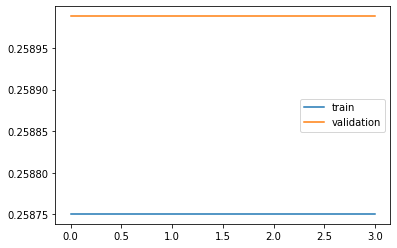

In [13]:
loss, accuracy = model2.evaluate(x_train, y_train, verbose=False)

import matplotlib.pyplot as plt


plt.plot(m2.history['accuracy'], label='train')
plt.plot(m2.history['val_accuracy'], label='validation')
plt.legend()
plt.show()